In [1]:
from influxdb import DataFrameClient
import json
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

In [2]:
config = load_config()
influx_client = DataFrameClient(**get_influxdb_info(config), database='ChameleonSimulator')

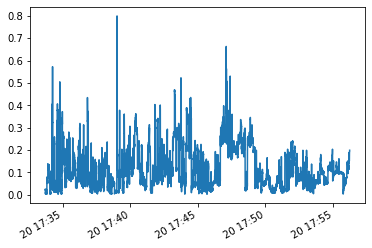

In [3]:
query_str = 'SELECT * FROM resource_pool'
df = influx_client.query(query_str)['resource_pool']
utl = 1-(df['ch-free']/(df['chi-inuse']+df['osg-inuse']+df['ch-free']))
utl.plot()
plt.show()

In [4]:
utl.mean(), utl.median(), utl.std()

(0.11426981444756285, 0.09220841056336831, 0.0900841902678389)

In [5]:
stop = df.iloc[-1].to_frame().T.index

In [6]:
query_str = 'SELECT * FROM osg_jobs'
osg = influx_client.query(query_str)['osg_jobs']
osg.reset_index(inplace=True)

In [7]:
times = [x for x in pd.to_datetime(osg['index']).to_list() if x < stop]
osg[osg['index'].isin(times)]

,index,completed,pending,running,terminated
0,2021-07-20 17:33:39.850517+00:00,0,0,0,0
1,2021-07-20 17:33:39.875870+00:00,0,0,0,0
2,2021-07-20 17:33:39.899542+00:00,0,0,0,0
3,2021-07-20 17:33:39.913412+00:00,0,0,0,0
4,2021-07-20 17:33:39.932125+00:00,0,0,0,0
...,...,...,...,...,...
53544,2021-07-20 17:56:13.433766+00:00,0,0,0,0
53545,2021-07-20 17:56:13.457258+00:00,0,0,0,0
53546,2021-07-20 17:56:13.474335+00:00,0,0,0,0
53547,2021-07-20 17:56:13.492130+00:00,0,0,0,0


In [8]:
import yaml

with open('config.yaml', 'r') as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as er:
        print(er)

{'simulation': {'scale_ratio': 100000, 'credential': {'username': 'chi-sim', 'password': 'chi-sim'}, 'enable_osg': False, 'enable_ml': False, 'enable_monitor': True}, 'framework': {'global_mgr': {'clean_run': True}, 'rsrc_mgr': {'host': '127.0.0.1'}, 'frontend': {'request_forecaster': {'window': 168, 'steps': 3, 'retrain': {'enabled': True, 'length': 30000}}}, 'databus': {'rabbitmq': '127.0.0.1'}, 'database': {'influxdb': '127.0.0.1', 'mongodb': '127.0.0.1'}}, 'workloads': {'machine_events': {'payload': '../datasets/machine_events/compute_haswell.csv', 'index_col': 0}, 'osg_jobs': {'payload': '../datasets/osg_jobs/osg_jobs.csv', 'index_col': 13}, 'chameleon_requests': {'payload': '../datasets/lease_info/compute_haswell.csv', 'index_col': 5}}}


In [5]:
import pymongo
from utils import *

config = load_config()
mongo_client = pymongo.MongoClient(get_mongo_url(config))
db = mongo_client['ChameleonSimulator']
osg_jobs_col = db['osg_jobs']

In [6]:
osg_jobs = osg_jobs_col.find()

In [7]:
osg_jobs = pd.DataFrame(list(osg_jobs))

In [8]:
osg_jobs

,_id,GlobalJobId,BlockReadKbytes,BlockWriteKbytes,CPUsUsage,CompletionDate,CpusProvisioned,DiskProvisioned,DiskUsage,DiskUsage_RAW,...,ResidentSetSize,MemoryUsage,JobSimSubmitDate,JobSimLastSubmitDate,JobSimLastStartDate,JobSimExpectCompleteDate,JobSimCompleteDate,JobSimStatus,ResubmitCount,Machine
0,60faf343db9dfed8fe6d3301,scott_grid_uchicago_edu#2537842_0#1624554816,0,0,0.997347,1624559408,1,8526265,257025,44,...,2978836,2910.018555,1.627059e+09,1.627059e+09,1.627059e+09,1.627063e+09,1.627063e+09,completed,0,38f89d8426232fb9b11f73b96e401286
1,60faf343db9dfed8fe6d3302,scott_grid_uchicago_edu#2537781_0#1624554807,0,0,0.997347,1624559416,1,8526265,257248,44,...,3008120,2938.616211,1.627059e+09,1.627059e+09,1.627059e+09,1.627063e+09,1.627063e+09,completed,0,38f89d8426232fb9b11f73b96e401286
2,60faf344db9dfed8fe6d3303,scott_grid_uchicago_edu#2537852_0#1624554817,0,0,0.998015,1624559416,1,8526265,255877,44,...,2954192,2885.952148,1.627059e+09,1.627059e+09,1.627059e+09,1.627063e+09,1.627063e+09,completed,0,3a9800c4b261fdc8595ed40da7568ccc
3,60faf344db9dfed8fe6d3304,scott_grid_uchicago_edu#2537855_0#1624554817,0,0,0.997348,1624559407,1,8526265,255635,44,...,2937928,2870.069336,1.627059e+09,1.627059e+09,1.627059e+09,1.627063e+09,1.627063e+09,completed,0,d376db654397449f49f3a5c77df35b04
4,60faf344db9dfed8fe6d3305,scott_grid_uchicago_edu#2537858_0#1624554818,0,0,0.997347,1624559416,1,8526265,256944,44,...,2945208,2877.178711,1.627059e+09,1.627059e+09,1.627059e+09,1.627063e+09,1.627063e+09,completed,0,eed618d03d23adb31c37870d8f291e79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306,60faf917db9dfed8fe6d5b49,login05_osgconnect_net#11306931_0#1624798335,0,0,0.996055,1625109677,1,17052512,39336,7712370,...,730968,714.834961,1.627059e+09,1.627060e+09,1.627060e+09,1.627165e+09,1.627165e+09,completed,0,eed618d03d23adb31c37870d8f291e79
10307,60faf917db9dfed8fe6d5b4a,login05_osgconnect_net#11300949_0#1624795852,0,0,0.995236,1625093495,1,17052512,39342,8005761,...,735956,719.706055,1.627059e+09,1.627060e+09,1.627060e+09,1.627166e+09,1.627166e+09,completed,0,76d4401795856426da8b2d45715f7c8b
10308,60faf917db9dfed8fe6d5b4b,login05_osgconnect_net#11310506_0#1624800865,0,0,0.995969,1625164724,1,17052512,39361,3890796,...,733472,717.280273,1.627059e+09,1.627060e+09,1.627060e+09,1.627166e+09,1.627166e+09,completed,0,75cacbbc14436846bcdbb565f4effb20
10309,60faf918db9dfed8fe6d5b4c,login05_osgconnect_net#11306018_0#1624797988,0,0,0.995037,1625103278,1,17052530,39343,8553690,...,727820,711.760742,1.627059e+09,1.627060e+09,1.627060e+09,1.627166e+09,1.627166e+09,completed,0,640783516818f97d17512aa2c6ecad76


In [10]:
exec_time = osg_jobs['JobSimCompleteDate'] - osg_jobs['JobSimSubmitDate']
exec_time

0          3705.353107
1          3708.586494
2          3702.989788
3          3700.925433
4          3699.028042
             ...      
10306    106391.516561
10307    106679.449004
10308    106923.793198
10309    107315.453151
10310    108622.576088
Length: 10311, dtype: float64

In [6]:
import time

start = time.time()
while time.time() - start < 0.0001:
    pass
end = time.time()
print(end-start)

0.000152587890625
